# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## MNIST GAN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Pavlos Protopapas, Mark Glickman and Chris Tanner<br/>
Author: Rashmi Banthia

<hr style="height:2pt">

##### Code merged from 
##### Tensorflow Tutorial - https://www.tensorflow.org/tutorials/generative/dcgan , Lab 10, ...


In [1]:
# system libraries 
import sys
import warnings
import os
import glob
import time
warnings.filterwarnings("ignore")

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

print(tf.__version__)

2.0.0


In [2]:
# from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [14]:

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
print(X_train.shape)

(60000, 28, 28, 1)


In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)

In [12]:
z_dim = 100

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    #adam = tf.keras.optimizers.Adam(lr=0.0003)
    return model

g = make_generator_model()
print(g.summary())
noise = tf.random.normal([1, 100])
generated_image = g(noise, training=False)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

d = make_discriminator_model()
print(d.summary())
adam = tf.keras.optimizers.Adam(lr=0.0002) # 1e-4, beta_1=0.5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
decision = d(generated_image)
print (decision)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [15]:
# Create GAN
d.trainable = False
inputs = tf.keras.layers.Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = tf.keras.Model(inputs, output)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5)    
gan.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [8]:
def show_images(imgs):
    n_imgs = imgs.shape[0]
    
    fig, ax = plt.subplots(1, n_imgs, figsize=(15, 20))
    plt.axis('off')
    for i in range(n_imgs):
        ax[i].imshow(np.clip(imgs[i].reshape(28,28), 0.0, 1.0), cmap='gray')
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()
    


In [9]:
d.metrics_names, gan.metrics_names #(['loss', 'accuracy'], ['loss', 'accuracy'])


(['loss', 'accuracy'], ['loss', 'accuracy'])

In [16]:
BATCH_SIZE = 256
epochs = 5 #70
noise_dim = (100,) #(128,)
losses = {"D":[], "G":[]}

y_smoother = 0.1
y_real = tf.ones((BATCH_SIZE,1))
y_fake = tf.zeros((BATCH_SIZE,1))


for epoch in range(epochs):
    
    start = time.time()
    
    i = 0
    for x_real in train_dataset:
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim[0]))
        x_fake = g.predict_on_batch(noise)
        
        # train discriminator
        d_loss_real = d.train_on_batch(x_real, y_real - y_smoother)
        
        d_loss_fake = d.train_on_batch(x_fake, y_fake)
        
        # train generator
        noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim[0]))
        dcgan_loss = gan.train_on_batch(noise, y_real)
        
    # Only store losses from final
    losses["D"].append((d_loss_real[0]+d_loss_fake[0])/2.)
    losses["G"].append(dcgan_loss[0])    
        
    print(f'Epoch: {epoch} \t Discr. Loss Real: {d_loss_real} \t Discr. Loss Fake: {d_loss_fake} \t DCGAN Loss: {dcgan_loss}')
    print("Time: ", time.time()-start) 
    
    # show_images(x_fake[:8])
    
    
    

Epoch: 0 	 Discr. Loss Real: [0.35976213, 0.0] 	 Discr. Loss Fake: [0.014850913, 1.0] 	 DCGAN Loss: [5.036689e-05, 1.0]
Time:  45.36532998085022
Epoch: 1 	 Discr. Loss Real: [0.39733896, 0.0] 	 Discr. Loss Fake: [0.14801988, 0.98828125] 	 DCGAN Loss: [0.052208286, 1.0]
Time:  45.093072175979614
Epoch: 2 	 Discr. Loss Real: [0.66555, 0.0] 	 Discr. Loss Fake: [0.5041108, 0.953125] 	 DCGAN Loss: [1.1279862, 0.0546875]
Time:  45.159114599227905
Epoch: 3 	 Discr. Loss Real: [0.79659206, 0.0] 	 Discr. Loss Fake: [0.619078, 0.95703125] 	 DCGAN Loss: [0.7111074, 0.15234375]
Time:  45.08081674575806
Epoch: 4 	 Discr. Loss Real: [0.7454694, 0.0] 	 Discr. Loss Fake: [0.60908294, 0.984375] 	 DCGAN Loss: [0.8813651, 0.01171875]
Time:  45.25439929962158


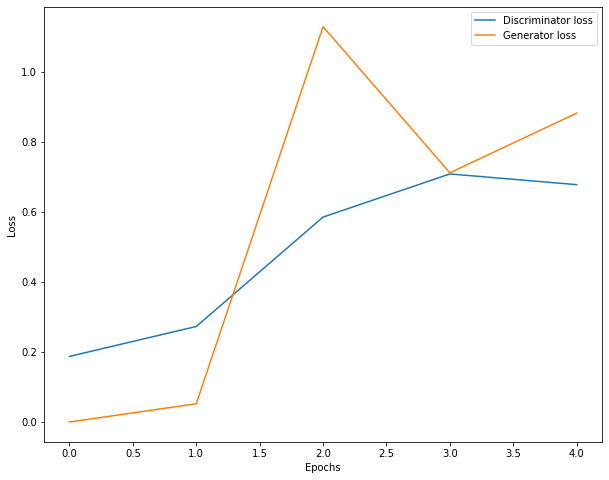

In [17]:
def plot_loss(losses):
    
    d_loss = [v for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_loss(losses)